# 📊 Advertising Sales Predictor

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (6, 4)

In [3]:
df = pd.read_csv('dataset/advertising.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head()

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


In [4]:
print("Shape of dataset:", df.shape)
print("\nColumn types:\n", df.dtypes)
print("\nMissing values:\n", df.isnull().sum())
print("\nDuplicates:", df.duplicated().sum())

Shape of dataset: (200, 4)

Column types:
 TV           float64
Radio        float64
Newspaper    float64
Sales        float64
dtype: object

Missing values:
 TV           0
Radio        0
Newspaper    0
Sales        0
dtype: int64

Duplicates: 0


In [5]:
print("\nSummary Statistics:\n", df.describe(include='all'))


Summary Statistics:
                TV       Radio   Newspaper       Sales
count  200.000000  200.000000  200.000000  200.000000
mean   147.042500   23.264000   30.554000   14.022500
std     85.854236   14.846809   21.778621    5.217457
min      0.700000    0.000000    0.300000    1.600000
25%     74.375000    9.975000   12.750000   10.375000
50%    149.750000   22.900000   25.750000   12.900000
75%    218.825000   36.525000   45.100000   17.400000
max    296.400000   49.600000  114.000000   27.000000


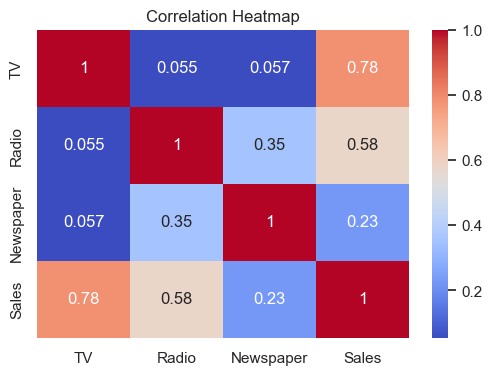

In [10]:
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

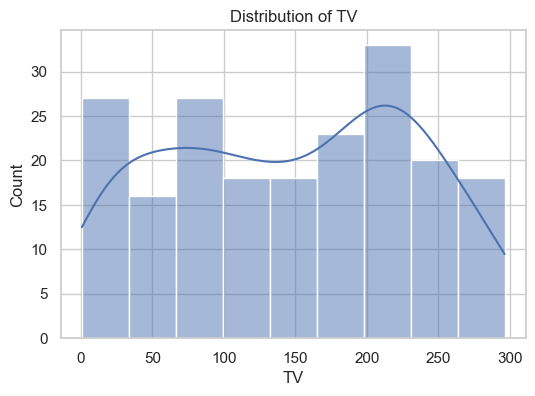

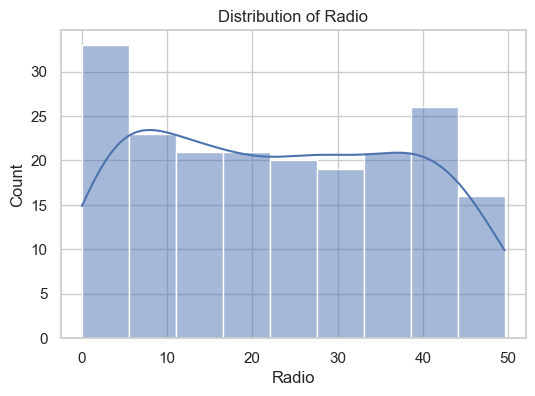

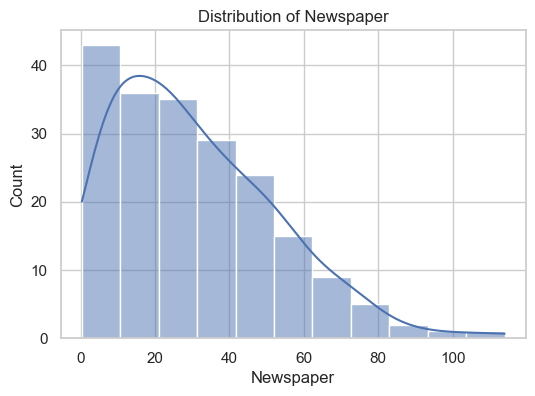

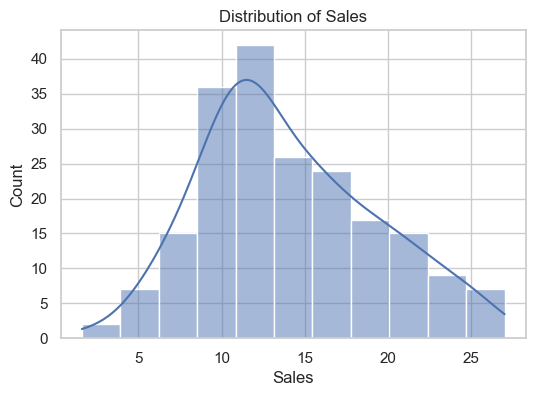

In [12]:
for col in df.select_dtypes(include=[np.number]).columns:
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

## Model Building

In [19]:
from sklearn.model_selection import train_test_split, GridSearchCV

X = df.drop('Sales', axis=1)
y = df['Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.head()

,TV,Radio,Newspaper
79,116.0,7.7,23.1
197,177.0,9.3,6.4
38,43.1,26.7,35.1
24,62.3,12.6,18.3
122,224.0,2.4,15.6


In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import ExtraTreesRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

model_params = {
    "Linear Regression": {"model": LinearRegression(), "params": {}},
    "Ridge Regression": {"model": Ridge(), "params": {"alpha": [0.1, 1.0, 10.0]}},
    "Lasso Regression": {"model": Lasso(), "params": {"alpha": [0.001, 0.01, 0.1, 1.0]}},
    "ElasticNet": {"model": ElasticNet(), "params": {"alpha": [0.01, 0.1, 1.0], "l1_ratio": [0.2, 0.5, 0.8]}},
    "Decision Tree": {"model": DecisionTreeRegressor(), "params": {"max_depth": [5, 10, 20]}},
    "Random Forest": {"model": RandomForestRegressor(), "params": {"n_estimators": [50, 100], "max_depth": [None, 10, 20]}},
    "Extra Trees": {"model": ExtraTreesRegressor(), "params": {"n_estimators": [100, 200], "max_depth": [10, 20]}},
    "AdaBoost": {"model": AdaBoostRegressor(), "params": {"n_estimators": [50, 100], "learning_rate": [0.05, 0.1, 0.5]}},
    "Gradient Boosting": {"model": GradientBoostingRegressor(), "params": {"n_estimators": [100, 200], "learning_rate": [0.05, 0.1]}},
    "Support Vector Regressor": {"model": SVR(), "params": {"C": [0.1, 1, 10], "kernel": ["rbf", "linear"]}},
    "KNN Regressor": {"model": KNeighborsRegressor(), "params": {"n_neighbors": [3, 5, 7]}},
    "XGBoost": {"model": XGBRegressor(), "params": {"n_estimators": [100, 200], "learning_rate": [0.05, 0.1]}},
    "CatBoost": {"model": CatBoostRegressor(verbose=0), "params": {"iterations": [100, 200], "learning_rate": [0.05, 0.1]}},
}

In [20]:
from sklearn.metrics import r2_score, mean_squared_error

results = []

for name, mp in model_params.items():
    model = mp["model"]
    param_grid = mp["params"]

    search = GridSearchCV(model, param_grid, cv=3, scoring='r2', n_jobs=-1)
    search.fit(X_train_scaled, y_train)
    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_scaled)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results.append((name, r2, rmse, search.best_params_))

# Results
results_df = pd.DataFrame(results, columns=["Model", "R2 Score", "RMSE", "Best Params"])
print("\nFinal Comparison:")
print(results_df.sort_values(by="R2 Score", ascending=False))


Final Comparison:
                       Model  R2 Score      RMSE  \
6                Extra Trees  0.990903  0.535850   
8          Gradient Boosting  0.983774  0.715652   
5              Random Forest  0.982186  0.749840   
11                   XGBoost  0.975211  0.884542   
9   Support Vector Regressor  0.974180  0.902755   
12                  CatBoost  0.967679  1.010036   
7                   AdaBoost  0.964490  1.058696   
4              Decision Tree  0.945539  1.311106   
10             KNN Regressor  0.930064  1.485742   
0          Linear Regression  0.899438  1.781600   
1           Ridge Regression  0.899377  1.782143   
3                 ElasticNet  0.899241  1.783347   
2           Lasso Regression  0.898336  1.791334   

                                    Best Params  
6        {'max_depth': 10, 'n_estimators': 200}  
8   {'learning_rate': 0.1, 'n_estimators': 200}  
5         {'max_depth': 20, 'n_estimators': 50}  
11  {'learning_rate': 0.1, 'n_estimators': 200}  
9 

In [21]:
model = ExtraTreesRegressor(max_depth=10, n_estimators=200)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

In [22]:
import joblib

joblib.dump(scaler, 'models/scaler.pkl')
joblib.dump(model, 'models/model.pkl')

['models/model.pkl']

In [24]:
new_data = pd.DataFrame([{
    "TV": 100,
    "Radio": 25,
    "Newspaper":20,
}])
new_data

,TV,Radio,Newspaper
0,100,25,20


In [25]:
new_data_scaled = scaler.transform(new_data)
prediction = model.predict(new_data_scaled)[0]
print("predicted sales price:", prediction)

predicted sales price: 13.2967892857143


Text(0.5, 1.0, 'Prediction vs Actual (with perfect-fit line)')

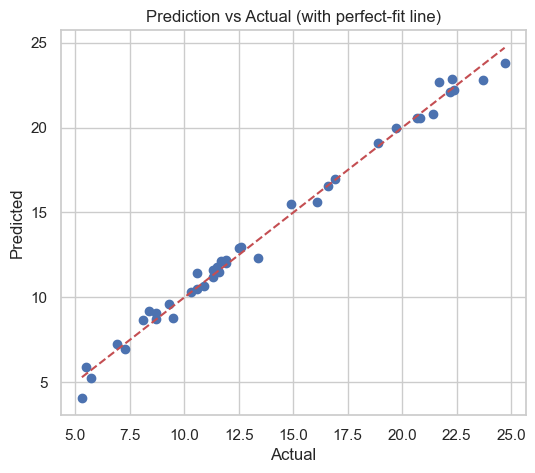

In [26]:
plt.figure(figsize=(6, 5))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Prediction vs Actual (with perfect-fit line)")